## SVM Implementation on scaled reduced dataset with LDA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_LDA.csv', names=['Data'])
X_train.head()

,Data
0,-1.257048
1,1.264925
2,-0.447008
3,-1.603004
4,1.306823


Read Test Data

In [5]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_LDA.csv', names=['Data'])
X_test.head()

,Data
0,-0.558286
1,-0.018074
2,0.140791
3,-1.844159
4,-0.044481


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [6]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [7]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [8]:
model = SVC(random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.7428381079280479
F1 score: [0.75738529 0.72643515]


## Grid Search CV - 1

In [9]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

model = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
The parameters with the highest score:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [10]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                              params  mean_test_score
0      {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}         0.735694
4       {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}         0.735110
8        {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.734944
24     {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}         0.734777
12        {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}         0.734694
16      {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.734694
28      {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}         0.734194
20       {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}         0.734194
1   {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}         0.733361
13     {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}         0.733361


Metrics for SVC-LDA-GS-CV1:
Accuracy: 0.7428
Weighted F1: 0.7422
Weighted Precision: 0.7437
Weighted Recall: 0.7428
Macro-Averaged Precision: 0.7440
Macro-Averaged Recall: 0.7417
F1: [0.75799373 0.72565743]
Precision: [0.73228346 0.75573649]
classification report
              precision    recall  f1-score   support

     Class 0       0.73      0.79      0.76      1539
     Class 1       0.76      0.70      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


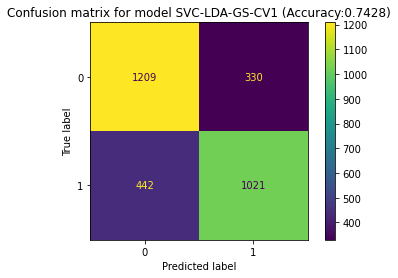

In [11]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('SVC-LDA-GS-CV1', y_test, predictions)

In [12]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = SVC(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7428381079280479
Parameters from place:  1   {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7428381079280479
Parameters from place:  2   {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7428381079280479
Parameters from place:  3   {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7431712191872085
Parameters from place:  4   {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7431712191872085
Parameters from place:  5   {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7431712191872085
Parameters from place:  6   {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7441705529646903
Parameters from place:  7   {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7435043304463691
Parameters

In [13]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [14]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.7441705529646903
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


Classification report of best model from alternatives of fine tuning

In [15]:
model = SVC(random_state=seed, **best_tuple[1])
model.fit(X_train, y_train)

predictions = model.predict(X_test)
current_accuracy = accuracy_score(y_test, predictions)

classification_report(y_test, predictions, zero_division=0)


'              precision    recall  f1-score   support\n\n           0       0.74      0.78      0.76      1539\n           1       0.75      0.71      0.73      1463\n\n    accuracy                           0.74      3002\n   macro avg       0.74      0.74      0.74      3002\nweighted avg       0.74      0.74      0.74      3002\n'

Metrics for SVC-LDA-alternatives:
Accuracy: 0.7442
Weighted F1: 0.7437
Weighted Precision: 0.7447
Weighted Recall: 0.7442
Macro-Averaged Precision: 0.7450
Macro-Averaged Recall: 0.7432
F1: [0.75788146 0.72881356]
Precision: [0.73606859 0.75383492]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1539
     Class 1       0.75      0.71      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


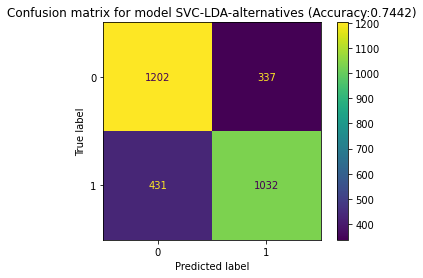

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
SVC-LDA-alternatives,0.744171,0.743715,0.744727,0.744171,0.744952,0.743213,[0.75788146 0.72881356],[0.73606859 0.75383492]


In [16]:
calculate_metrics('SVC-LDA-alternatives', y_test, predictions)